### Calculating the confidence intervals (CI) from FYP - (3) Drift

NOTE: The code for the CI was not written by me but by my supervisor Tin-Yu Hui.

In [24]:
require(compiler)
require(hdf5r)

In [64]:
# LOAD THE FIRST POPULATION. 2013 HDF5
dat1<-H5File$new('2013_3R_int_10.hdf5', 'r')
# LOAD THE SECOND POPULATION. 2015 HDF5
dat2<-H5File$new('2015_3R_int_10.hdf5', 'r')
# maf>=0.1 FOR THE FIRST TEMPORAL SAMPLE, NO REQUIREMENT FOR THE SECOND

In [65]:
dat1
dat2

Class: H5File
Filename: C:\Users\isabe\OneDrive - Imperial College London\Final Year Project\2013_3R_int_10.hdf5
Access type: H5F_ACC_RDONLY
Listing:
     name    obj_type   dataset.dims dataset.type_class
      POS H5I_DATASET          13580        H5T_INTEGER
 genotype H5I_DATASET 2 x 73 x 13580        H5T_INTEGER

Class: H5File
Filename: C:\Users\isabe\OneDrive - Imperial College London\Final Year Project\2015_3R_int_10.hdf5
Access type: H5F_ACC_RDONLY
Listing:
     name    obj_type    dataset.dims dataset.type_class
      POS H5I_DATASET           13580        H5T_INTEGER
 genotype H5I_DATASET 2 x 104 x 13580        H5T_INTEGER

In [66]:
# READ genotype AS R ARRAY, 3D
genotype1<-dat1[['genotype']][,,]
dim(genotype1)
unique(as.numeric(genotype1))
# DO THE SAME FOR 2015 HDF5
genotype2<-dat2[['genotype']][,,]
dim(genotype2)
unique(as.numeric(genotype2))

[1]     2    73 13580

[1] 1 0 2 3

[1]     2   104 13580

[1] 0 1 2 3

In [67]:
POS<-dat1[['POS']][]

In [68]:
# FUNCTION TO RETURN THE FOUR ALLELE COUNTS. PER LOCUS
allele.count<-function(GT)
{
    a1<-GT[1,]
    a2<-GT[2,]
    a<-c(a1, a2)
    return(c(sum(a=='0'), sum(a=='1'), sum(a=='2'), sum(a=='3')))
}

# FUNCTION TO RETURN NUMBER OF ALLELES. PER LOCUS
allelism<-function(allele_count)
{
    return(sum(allele_count>0))
}

# FUNCTION TO CONVERT COUNT TO FREQUENCY, PER LOCUS
allele.frequency<-function(allele_count)
{
    y<-allele_count[1]+allele_count[2]+allele_count[3]+allele_count[4]
    return(allele_count/y)
}

# FUNCTION TO RETURN WHICH LARGEST FREQ? PER LOCUS
# 1 RETURN THE LARGEST, 2 RETURN MAF, ETC
cal.frequency<-function(allele_frequency, which=1)
{
    return(allele_frequency[order(allele_frequency, decreasing=T)[which]])
}

# FUNCTION TO RETURN THE WHICH LARGEST ALLELE (0, 1, 2, 3?) PER LOCUS
# 1 RETURN THE LARGEST
find.allele<-function(allele_count, which=1)
{
    return(order(allele_count, decreasing=T)[which]-1)
}

# FUNCTION TO CONVERT MULTIALLELIC LOCI INTO BIALLELIC (GROUP REMAINING THREE AS ALT)
# RETURN NUMERIC. 0 (REF HOMOZYGOTE), 1 (HETEROZYGOTE), 2, MISSING IS NA
to.biallelic<-function(GT, ref='0')
{
    a1<-GT[1,]
    a2<-GT[2,]
    b1<-1-(a1==ref)
    b2<-1-(a2==ref)
    return(b1+b2)
}

In [69]:
# FIND ALLELE COUNT
allele_count1<-t(apply(genotype1, 3, allele.count))
dim(allele_count1)
allele_count1[1,]
# TO ALLELE FREQ
af1<-t(apply(allele_count1, 1, allele.frequency))
dim(af1)
af1[1,]
# FIND MAJOR ALeLE FREQ AND ITS SUMMARY
major_f1<-apply(af1, 1, cal.frequency, which=1)
length(major_f1)
# FIND THE MAJOR ALLELE 
major_allele1<-apply(allele_count1, 1, find.allele, which=1)

[1] 13580     4

[1] 47 99  0  0

[1] 13580     4

[1] 0.3219178 0.6780822 0.0000000 0.0000000

[1] 13580

In [71]:
# CONVERT TO GENOTYPE MATRIX (WITH 0, 1, 2 ONLY, 0 IS THE MAJOR ALLELE)
g1<-matrix(nc=dim(genotype1)[2], nr=dim(genotype1)[3])
g2<-matrix(nc=dim(genotype2)[2], nr=dim(genotype2)[3])
for (i in 1:nrow(g1))
{
    g1[i,]<-to.biallelic(genotype1[,,i], ref=major_allele1[i])
    g2[i,]<-to.biallelic(genotype2[,,i], ref=major_allele1[i])
}
dim(g1)
dim(g2)
unique(as.numeric(g1))
unique(as.numeric(g2))

[1] 13580    73

[1] 13580   104

[1] 0 1 2

[1] 1 0 2

In [72]:
# THE TWO SAMPLE SIZES
s1<-ncol(g1)
s2<-ncol(g2)
s1
s2
# NUMBER OF LOCI 
K<-nrow(g1)
K

[1] 73

[1] 104

[1] 13580

In [73]:
# RECALCULATE THE TWO ALLELE FREQ AGAIN
f1<-apply(g1, 1, sum)/(2*s1)
f2<-apply(g2, 1, sum)/(2*s2)

# TEMPORAL Fc
Fa<-mean((f1-f2)^2/(f1*(1-f1)))
Fa

# SIZE OF SAMPLING ERROR 
0.5/s1+0.5/s2

# MINUS SAMPLING ERROR
Fa-0.5/s1-0.5/s2

[1] 0.01125645

[1] 0.01165701

[1] -0.0004005532

RESULTS:
- Sampling error same for all: 0.0116570073761855

- fa_X_int: 0.0118885280123931
- fa_X_int_se: 0.000231520636207599

- fa_X_4: 0.0111445581858069
- fa_X_4_se: -0.000512449190378569

- fa_3R_4: 0.0112449825807431
- fa_3R_4_se: -0.00041202479544232

- fa_3R_int: 0.0112564541599081
- fa_3R_int_se: -0.00040055321627739



In [74]:
# Ne ESTIMATE, 20 GENERATIONS APART?
t<-20
N<-t/(2*(Fa-0.5/s1-0.5/s2))
N

[1] -24965.47

In [75]:
# EXPLICITLY TELL R THAT g1 IS A MATRIX OF INTEGERS
mode(g1)<-'integer'
# CALCULATE R MATRIX AND EIGENVALUES FOR Fa
# ONLY CHANGE THE 39033 TO YOUR Ne ESTIMATE. IF THE ESTIMATE IS NEGATIVE, JUST SAY 1e6 (ONE MILLION)
dyn.load("C:/Users/isabe/OneDrive - Imperial College London/r_matrix.dll")
R <- .Call('cal_corr_matrix_unphased', t(g1), as.integer(POS), 0.032, # Change recombination rate for X (0.011) and 3R (0.032)
           as.integer(1e6), 
           as.integer(s1), as.integer(s2), as.integer(t), 4)
dyn.unload("C:/Users/isabe/OneDrive - Imperial College London/r_matrix.dll")
e <- eigen(R, only.values=TRUE)
gc()

Using 4 cores. 


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,738320,39.5,1207595,64.5,1207595,64.5
Vcells,190253866,1451.6,856821642,6537.1,1020119242,7782.9


In [76]:
# C.I. WITH Fa
gen_Q2 <- function(eigenvalues)
{
  working_eigenvalues <- eigenvalues[eigenvalues>0]
  working_eigenvalues <- working_eigenvalues*sum(eigenvalues)/sum(working_eigenvalues)
  dyn.load("C:/Users/isabe/OneDrive - Imperial College London/r_matrix.dll")
  y <- .Call('generate_Q2', working_eigenvalues, 50000)
  dyn.unload("C:/Users/isabe/OneDrive - Imperial College London/r_matrix.dll")
  return(y)
}
# EMPIRICAL Q2 DISTRIBUTION. YOU WILL GET A SLIGHTLY DIFFERENT Q2 BECAUSE OF RANDOMNESS
Q2<-gen_Q2(e$values)

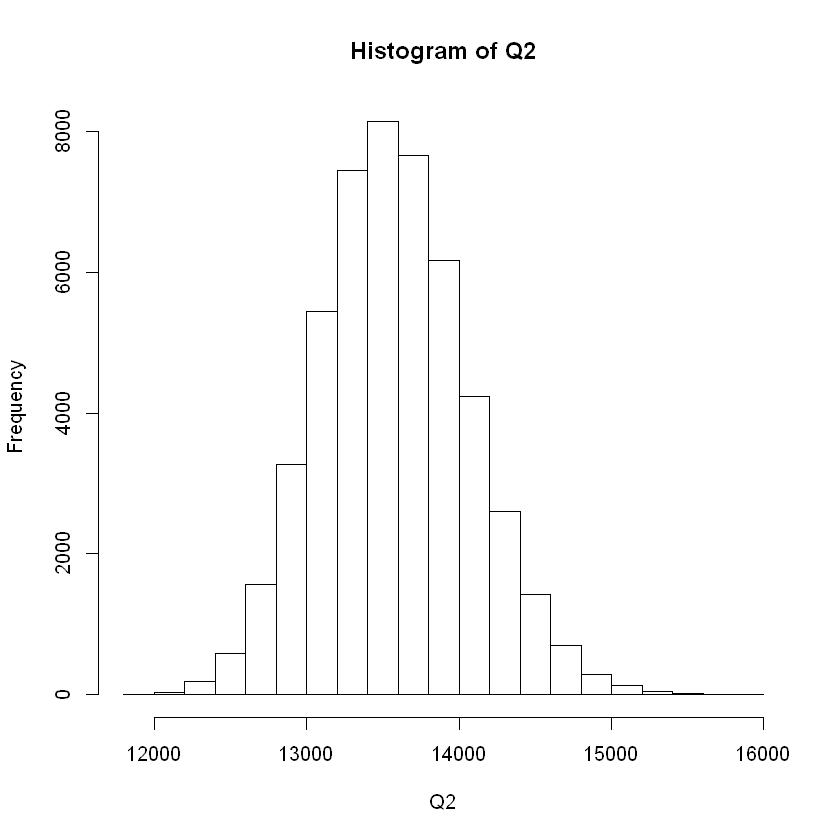

In [77]:
hist(Q2)

In [78]:
# LOWER CI FOR Fa
F_lower<-K*Fa/quantile(Q2, 0.975)
# UPPER CI FOR Fa
F_upper<-K*Fa/quantile(Q2, 0.025)
c(F_lower, Fa, F_upper)

97.5%                  2.5% 
0.01047798 0.01125645 0.01206243

Results:
- X_int
    - 97.5% 0.0106355463067176
    - 2 0.0118885280123931
    - 2.5% 0.0132592031789685
    
- X_4
    - 97.5% 0.00956512448725907
    - 2 0.0111445581858069
    - 2.5% 0.0130109408072938
    
- 3R_4
    - 97.5% 0.0102342291518286
    - 2 0.0112449825807431
    - 2.5% 0.0123396956240277
    
- 3R_int
    - 97.5% 0.0104779779238563
    - 2 0.0112564541599081
    - 2.5% 0.012062429415943
  

In [79]:
# LOWER CI FOR Ne, FROM THE UPPER CI F
N_lower<-t/(2*(F_upper-0.5/s1-0.5/s2))
N_lower

N_upper<-t/(2*(F_lower-0.5/s1-0.5/s2))
N_upper

c(N_lower, N, N_upper) # Negative means infinity

2.5% 
24665.65

97.5% 
-8481.552

2.5%                 97.5% 
 24665.655 -24965.472  -8481.552

Results:
- X_int
    - 2.5% 6241.43440060828
    - 2 43192.6940241872
    - 97.5% -9789.89831223785
    
- X_4
   - 2.5% 7385.88749656176
   - 2 -19514.1297669191
   - 97.5% -4780.38233064389
   
- 3R_4
    - 2.5% 14647.9744328492
    - 2 -24270.3839929457
    - 97.5% -7028.50228433905
    
- 3R_int
    - 2.5% 24665.6546002707
    - 2 -24965.4717366564
    - 97.5% -8481.55233123725

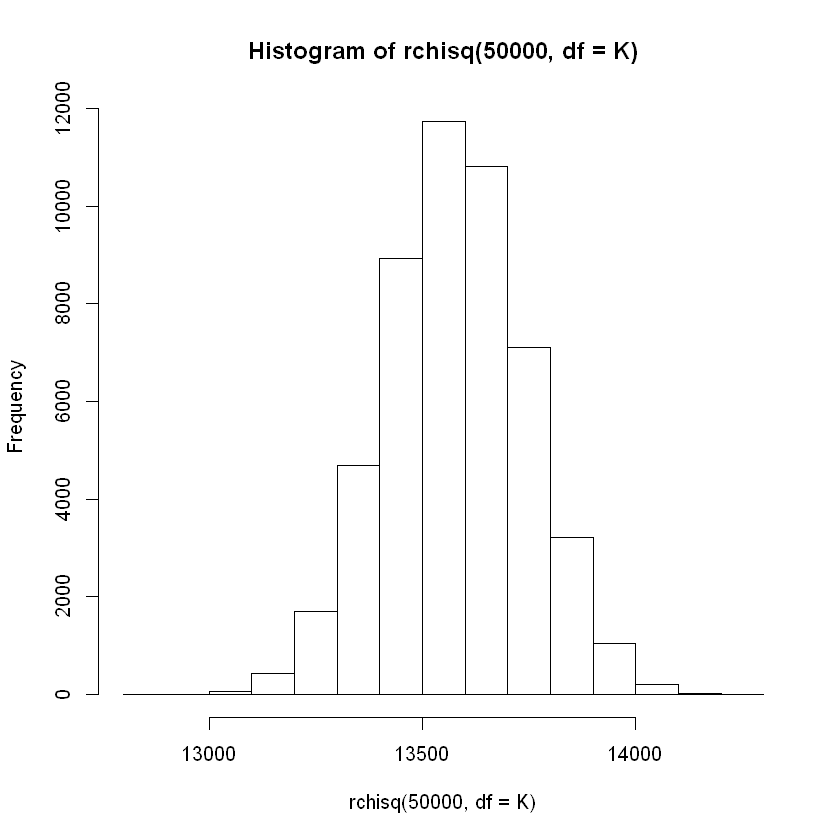

In [80]:
# COMPARISON, CHI-SQUARE WITH K DEGREES OF FREEDOM
# IT IS MUCH NARROWER THAN THE ONE ABOVE
hist(rchisq(50000, df=K))

In [82]:
R.Version()
# 3.6.1

$platform
[1] "x86_64-w64-mingw32"

$arch
[1] "x86_64"

$os
[1] "mingw32"

$system
[1] "x86_64, mingw32"

$status
[1] ""

$major
[1] "3"

$minor
[1] "6.1"

$year
[1] "2019"

$month
[1] "07"

$day
[1] "05"

$`svn rev`
[1] "76782"

$language
[1] "R"

$version.string
[1] "R version 3.6.1 (2019-07-05)"

$nickname
[1] "Action of the Toes"